# JobSeekerAgency: an Agentic Workflow to make the whole process of find your next dream job effortless

In [1]:
import sys
sys.path.append('../python')
sys.path.append('../../keys')

In [98]:
%load_ext autoreload
%autoreload 2

import os
import subprocess as sub

from langchain.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import Document
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain.document_loaders import WikipediaLoader

from langchain.document_loaders import CSVLoader

# chains
from langchain.chains import LLMChain, SequentialChain, SimpleSequentialChain, RouterChain, TransformChain
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser

# memory
from langchain.memory import ChatMessageHistory, ConversationBufferMemory, ConversationBufferWindowMemory, ConversationSummaryBufferMemory
from langchain.chains import ConversationChain
import pickle
# Agents
from langchain.agents import load_tools, initialize_agent, AgentType, tool

# RAG
import chromadb
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

## LangGraph
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from operator import add
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

## OpenAI
from openai import OpenAI 

## Custom scripts:
import Constants as C
from tools import *

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY

## Functions

## Tools

## Main

In [100]:
# define your GPT chat model
client = OpenAI()
tools  = [get_NOVARTIS_jobs,get_AWS_jobs,coolest_guy]
gpt    = ['gpt-4o-mini','gpt-5','gpt-5-nano'][0]
model  = ChatOpenAI(model=gpt,openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)

In [101]:
from langchain.output_parsers import PydanticOutputParser

In [102]:
class JobList(BaseModel):
    name: str = Field(description='Name of the job')
    url: list = Field(description='The url of the job')

In [103]:
class ChatMessages(TypedDict):
    messages: List[BaseMessage] # the BaseMessages for agents
    company: str
    question: HumanMessage # store the original question
    codescript: str # the script written by code-writer agent
    codeiter: int # keeps track of many times code has been modified
    joblist: str # the job list results from parsing career page
    # mytools: List[{}] # the list of tools to access the company jobs # !! YOU CANNOT PASS TOOLS HERE, OTHERWISE ERROR!!
    company2careerpage: dict # associates the company with their jobs postings

## Nodes / Agents
## --------------------------------------------------

def call_agent(state):
    """
    First pass to know what to do, if it cannot find a tool to extract job list, then refer to code-writing agent
    """

    print(f'\n>> First pass >>\n')
    
    if "messages" not in state or state["messages"] is None:
        # print('!!! INITIALIZING MESSAGES STATE !!!')
        state["messages"] = []
        state["messages"].append(state["question"])

    system_message = SystemMessage(
        content="""if you get the job list, can you simply output it without any further comments? If not please return 'No'
        """
    )
    state["messages"].append(system_message)
    
    ## preping the agent with tools    
    prompt   = ChatPromptTemplate.from_messages(state['messages']).format()
    model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)
    response = model.invoke(prompt) # you are calling the llm here!
    
    state['messages'].append(response)
    print(state['messages'].content)
    return state

def joblist_formatting(state):
    """
    Simply takes the list of job list string and formats to json
    """

    print(f'\n>> Formatting job list >>\n')
    
    messages = state['messages']
    # state["messages"].append(system_message)
    state['joblist'] = messages[-1].content
    print(state['joblist'])
    return state
    

def code_writing(state):
    """
    Agent writing the code to retrieve jobs for companies
    """
    
    print(f'\n>> Code Writing, iteration {state['codeiter']}>>\n')

    # define the system message
    system_message = SystemMessage(
        content="""You are an expert programmer that is ready to help write some clean and concise python code. Please ensure that:

        1. you use beautiful soup and async_playwright
        2. you should only output python code
        """
    ) # 3. the ouptut of the code should be a list of job names followed by their application url
    # 3. you end with with 'await main()' instead of 'asyncio.run(main())
    sel_               = state['company']
    company2careerpage = state['company2careerpage']
    question   = f"""can you write a short python code to list the jobs from the company {sel_} career page ({company2careerpage[sel_]})?""" 

    state["messages"].append(HumanMessage(content=question))
    state["messages"].append(system_message)
    # print('> question:',state["question"])
    
    if 1<3:
        # define the messages
        messages = state['messages']
        prompt   = ChatPromptTemplate.from_messages(messages).format()
        # select coding model (here gpt 5)
        model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0)
        # get response and prb
        response = model.invoke(prompt) # you are calling the llm here!
        state['messages'].append(response) # don't forget to add message to the response!
        state['codescript'] = state['messages'][-1].content #
        state['codeiter'] += 1
        
    return state

# making sure the answer is in a correct structure

# class Grade_code_eval(BaseModel):
#     """
#     Boolean value to check whether the code passed all criteria
#     """
#     score: str = Field(
#         description="Did the code generate the desired output without errors? If yes -> 'Yes' if not not -> 'No'"
#     )

def code_eval(state):
    """
    Agent responsible for making sure the code is running
    """

    print('\n>> Code Evaluation >>\n')

    if 1 < 3:
        # save code to file to check whether it works
        with open("../tmp/tmp.py", "w") as f:
            f.write(state['codescript'])
        f.close()
    
    # run and check outputs
    p = sub.run( 'python ../tmp/tmp.py',shell=True, capture_output=True )
    exit_status = '\n* exit status: '+ str(p.returncode)
    stdout      = '\n* stdout: ' + p.stdout.decode()
    stderr      = '\n* stderr:' + p.stderr.decode()
    print( exit_status )
    print( stdout )
    print( stderr )

    state['joblist'] = p.stdout.decode()
    
    ## use LLM to check whether the code was run correcly and ouptut matches expectation, otherwise return code to code writer
    # define the system message
    system_message = SystemMessage(
        content="""You are an expert code evaluator, you will carefully check that the code runs by making sure that:

        1. the exit status is 0
        2. there is no stderr
        3. the stdout output looks like a list of job description followed by their application link and date posted (if date posted is available)

        If all pass, respond with 'Yes'. Otherwise, respond with the error message.
        """
    )
    
    question   = f'Check whether the code ran successfully based on the following output {exit_status+stdout+stderr} '

    state["messages"].append(HumanMessage(content=question))
    state["messages"].append(system_message)

    # define the messages
    messages = state['messages']
    prompt   = ChatPromptTemplate.from_messages(messages).format()
    # select coding model (here gpt 5)
    model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0)
    # get response and prb
    response = model.invoke(prompt)    # you are calling the llm here!
    print('\n> response:',response.content)
    state['messages'].append(response) # don't forget to add message to the response!
    # update the request in case we need to re-write the code
    question = f'The following code "{state['codescript']}" got this error: "{response.content}" - can you re-write the code by fixing the error?'
    state["question"] = HumanMessage(content=question)
    
    return state

## Bifurcation / conditional edges
## --------------------------------------------------

def Are_tools_used(state)-> Literal["tools","coderWriter",END]:
    
    print('\n>> Are tools used? >>\n')
    
    messages     = state['messages']
    last_message = messages[-1]
    # print(last_message)
    if last_message.tool_calls:
        print('> calling tool')
        return "tools"
    elif last_message.content == 'No':
        return "coderWriter"
    return END
    
def Is_code_ok_YN(state) -> Literal['coderWriter',END]:
    """
    If the code did not pass all desirability criteria, returns to code writer for correction
    """
    messages = state['messages']
    
    print('\n>> Is_code_ok_YN >> \n')
    
    last_message = state['messages'][-1].content
    # if 
    if last_message == 'Yes' or state['codeiter'] > 5:
        print('> calling tools\n')
        return END # calls the tools node here
    else:
        print('> returning code to code writer')
        return 'coderWriter'
        
    return END

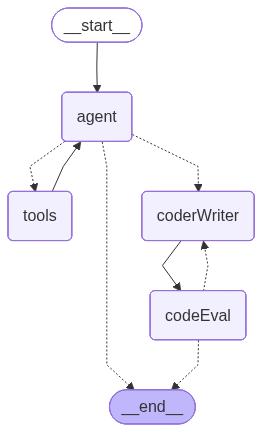

In [104]:
tool_node = ToolNode(tools)

workflow = StateGraph(ChatMessages)

## adding nodes
workflow.add_node('agent',call_agent)
workflow.add_node('tools',tool_node)
workflow.add_node('formatter',joblist_formatting)

## adding edges and routing
workflow.add_edge(START,'agent')
workflow.add_conditional_edges('agent',Are_tools_used) # setting router function for the agent
workflow.add_edge('tools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human

if 1<3:
    # Nodes
    workflow.add_node('coderWriter',code_writing)
    workflow.add_node('codeEval',code_eval)
    
    # workflow.add_node('tools',tool_node)
    
    # edges
    # workflow.add_edge(START,'coderWriter')
    workflow.add_edge('coderWriter','codeEval')
    workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent
    # workflow.add_edge('tools','coder') # you want to link tools to agent because agent is responsible for giving an answer to human
    # workflow.add_edge('agent',END)

checkpointer = MemorySaver() # set memory
graph = workflow.compile() # checkpointer=checkpointer 
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [105]:
%%time
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
    'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4'
}
# 'Can you tell me who is the coolest guy in the universe?' #
select     = 'AWS'
question   = f'can you simply get the current jobs associated with this company {select}?'
# question = 'can you tell me who is the coolest guy in the universe?'
# question   = f"""can you write a short python code to list the jobs from the company {select} career page ({company2careerpage[select]})?""" 

input_data = {"question": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
res1       = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})


>> First pass >>

[HumanMessage(content='can you simply get the current jobs associated with this company AWS?', additional_kwargs={}, response_metadata={}), SystemMessage(content="if you get the job list, can you simply output it without any further comments? If not please return 'No'\n        ", additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b2J76vpqPYIJRaa82uuPqEFQ', 'function': {'arguments': '{}', 'name': 'get_AWS_jobs'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 277, 'prompt_tokens': 241, 'total_tokens': 518, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CTUXjxJ1O3xJfQ68MDNjwLcnoF3ns', 'service_tier': 'default', 'finish_reaso

In [107]:
print(res1['messages'][-1].content)

Senior Solutions Architect, Generative AI, Startups, AWS - https://www.amazon.jobs/jobs/3108132
Senior Solutions Architect - Healthcare & Life Sciences, Senior Solutions Architect HCLS - https://www.amazon.jobs/jobs/3107017
Senior Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059726
Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059723
Senior Delivery Consultant - Machine Learning (GenAI), ProServe EMEA, ProServe EMEA - https://www.amazon.jobs/jobs/3059727
Delivery Consultant - Machine Learning (GenAI), ProServe EMEA - https://www.amazon.jobs/jobs/3059724


In [45]:
# print(res1['joblist'])

In [188]:
# # with open("../tmp/tmp.py", "w") as f:
# #     f.write(res1['codescript'])
# # f.close()
# # sub.call('python ../tmp/tmp.py',shell=True)
# p = sub.run( 'python ../tmp/tmp.py',shell=True, capture_output=True )

# print( '\n* exit status:', p.returncode )
# print( '\n* stdout:', p.stdout.decode() )
# print( '\n* stderr:', p.stderr.decode() )

Yes


In [200]:
# import ollama
# response = ollama.web_search("What is Ollama?")
# print(response)

#### CSL

In [82]:
import asyncio
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright

URL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto(URL, wait_until="domcontentloaded")
        # Wait for job cards to render
        try:
            await page.wait_for_selector('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]', timeout=20000)
        except:
            pass
        html = await page.content()
        await browser.close()

    soup = BeautifulSoup(html, "html.parser")
    jobs = []
    for a in soup.select('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]'):
        title = a.get_text(strip=True)
        href = urljoin(URL, a.get("href") or "")
        if title and href:
            jobs.append({"title": title, "url": href})

    for j in jobs:
        print(f"{j['title']} - {j['url']}")

if __name__ == "__main__":
    await main() # to be run in Jupyter Notebook
    ## asyncio.run(main()) # to be run via command line
    

Senior Operational Support Scientist & Stv. Abteilungsleiter:in - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Senior-Operational-Support-Scientist---Stv-Team-Lead_R-260905?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Operational Support Scientist - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Operational-Support-Scientist_R-262772?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Pharmafachmitarbeiter/in Vorbereitungsgruppe Filling Line VI - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Vorbereitungsgruppe_R-261978?locationCountry=187134fccb084a0ea9b4b95f23890dbe
Sales Representative Primary Care - Basel, Aargau und Zentralschweiz - https://csl.wd1.myworkdayjobs.com/en-US/CSL_External/job/EMEA-CH-Remote-CSL-Vifor/Sales-Representative-Primary-Care---Basel--Aargau-und-Zentralschweiz_R-259876?locationCountry=187134fccb084a0ea9b4b95f23890dbe


#### Visium

In [ ]:
# import asyncio
# from urllib.parse import urljoin
# from playwright.async_api import async_playwright
# from bs4 import BeautifulSoup

# async def fetch_visium_jobs():
#     url = "https://www.visium.com/join-us#open-positions"
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         page = await browser.new_page()
#         await page.goto(url, wait_until="networkidle")
#         # Give JS time to hydrate listings if needed
#         await page.wait_for_timeout(1500)
#         html = await page.content()
#         await browser.close()

#     soup = BeautifulSoup(html, "html.parser")
#     container = soup.select_one("#open-positions") or soup

#     jobs = []
#     for a in container.select("a[href]"):
#         title = a.get_text(strip=True)
#         href = a["href"].strip()
#         if not title or href.startswith("#"):
#             continue
#         full_url = urljoin("https://www.visium.com/", href)
#         # Heuristic filter for job-like links
#         if any(k in href.lower() for k in ("jobs", "careers", "positions", "greenhouse", "lever", "apply", "join")):
#             jobs.append({"title": title, "url": full_url})
#     return jobs

# async def main():
#     jobs = await fetch_visium_jobs()
#     for j in jobs:
#         print(f"- {j['title']}: {j['url']}")

# if __name__ == "__main__":
#     await main()

#### Lenovo

In [ ]:
# URL = "https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&"

# async def fetch_html(url: str) -> str:
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         context = await browser.new_context(
#             user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
#             locale="en-US"
#         )
#         page = await context.new_page()
#         await page.goto(url, wait_until="networkidle", timeout=60000)
#         # small scroll to trigger any lazy content (optional)
#         await page.evaluate("window.scrollTo(0, document.body.scrollHeight)")
#         await page.wait_for_timeout(500)
#         html = await page.content()
#         await browser.close()
#         return html

# async def main():
#     html = await fetch_html(URL)
#     soup = BeautifulSoup(html, "lxml")

#     print("Page title:", soup.title.get_text(strip=True) if soup.title else "N/A")

#     # Heuristic selectors for job cards/titles (adjust as needed)
#     titles = [a.get_text(strip=True) for a in soup.select(
#         'a[data-ph-at-id="job-title"], a[aria-label*="Job"], a[title*="Job"], h2, h3'
#     )]
#     # Deduplicate and show a few
#     seen, cleaned = set(), []
#     for t in titles:
#         if t and t not in seen:
#             seen.add(t)
#             cleaned.append(t)
#     for t in cleaned[:10]:
#         print("-", t)

# if __name__ == "__main__":
#     await main()

#### AWS

In [31]:
# from bs4 import BeautifulSoup
# from playwright.async_api import async_playwright

# URL = "https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect"

# async def main():
#     async with async_playwright() as p:
#         browser = await p.chromium.launch(headless=True)
#         context = await browser.new_context()
#         page = await context.new_page()
#         await page.goto(URL, wait_until="networkidle")
#         html = await page.content()
#         await browser.close()

#     soup = BeautifulSoup(html, "html.parser")
#     seen, jobs = set(), []
#     for a in soup.select('a[href*="/jobs/"]'):
#         href = a.get("href")
#         if not href:
#             continue
#         url = href if href.startswith("http") else f"https://www.amazon.jobs{href}"
#         title = a.get_text(strip=True)
#         if url not in seen and title:
#             seen.add(url)
#             jobs.append((title, url))

#     for title, url in jobs:
#         print(f"{title} - {url}")

# await main()

#### Allowing agent to run python code:

In [137]:
from langchain_openai import ChatOpenAI
from langchain.agents import initialize_agent, AgentType
from langchain.tools import ShellTool  # runs terminal commands

llm = ChatOpenAI(model=["gpt-4o-mini","gpt-5"][0], temperature=0)
agent = initialize_agent(
    tools=[ShellTool()],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
)

# Ask it to run python from terminal:
resp = agent.invoke({"input": f'Run this `python -c "{res1['codescript']}"` and give me the output.'})

Executing command:
 python3 -m pip show playwright beautifulsoup4  

Executing command:
 python3 -c "import re
from typing import List, Dict
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright


URL = 'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe'


async def collect_all_results(page):
    selectors = [
        'button[data-automation="searchShowMore"]',
        'button:has-text("Load more")',
        'button:has-text("Show more")',
        'button:has-text("Mehr laden")',
    ]
    while True:
        clicked = False
        for sel in selectors:
            loc = page.locator(sel)
            if await loc.count() > 0 and await loc.first().is_enabled():
                try:
                    await loc.first().click()
                    await page.wait_for_timeout(800)
                    clicked = True
                    break
                except Exception:
                    pass
        if n

In [139]:
print(resp["output"])

The script executed successfully and returned job listings, but the location and job ID fields were mostly empty. Here are some of the job titles retrieved:

1. Senior Operational Support Scientist & Stv. Abteilungsleiter:in |  |  | /en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Senior-Operational-Support-Scientist---Stv-Team-Lead_R-260905?locationCountry=187134fccb084a0ea9b4b95f23890dbe
2. Operational Support Scientist |  |  | /en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Operational-Support-Scientist_R-262772?locationCountry=187134fccb084a0ea9b4b95f23890dbe
3. Pharmafachmitarbeiter/in Vorbereitungsgruppe Filling Line VI |  |  | /en-US/CSL_External/job/EMEA-CH-Kanton-Bern-Bern-CSL-Behring/Vorbereitungsgruppe_R-261978?locationCountry=187134fccb084a0ea9b4b95f23890dbe
4. Sales Representative Primary Care - Basel, Aargau und Zentralschweiz |  |  | /en-US/CSL_External/job/EMEA-CH-Remote-CSL-Vifor/Sales-Representative-Primary-Care---Basel--Aargau-und-Zentralschw

In [112]:
code2run = """
import asyncio
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from playwright.async_api import async_playwright

URL = "https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe"

async def main():
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()
        await page.goto(URL, wait_until="domcontentloaded")
        # Wait for job cards to render
        try:
            await page.wait_for_selector('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]', timeout=20000)
        except:
            pass
        html = await page.content()
        await browser.close()

    soup = BeautifulSoup(html, "html.parser")
    jobs = []
    for a in soup.select('a[data-automation-id="jobTitle"], a[data-automation-id="jobTitleLink"]'):
        title = a.get_text(strip=True)
        href = urljoin(URL, a.get("href") or "")
        if title and href:
            jobs.append({"title": title, "url": href})

    for j in jobs:
        print(f"{j['title']} - {j['url']}")


main()"""